# Exploration of electricity and weather data 

#### Key points
1. Trend through time (month, day, hour)
2. Minimum and maximum of consumption per time frame
3. Correlations between variables:
      - Consumption vs. time of year
      - Consumptions vs. weather 

## 1. Trend analysis - date and time

In [72]:
# Import libraries for plotting, reading and wrangling data
library(ggplot2)
library(cowplot)
library(gridExtra)
library(readr)
library(dplyr)
library(tibble)
library(grid)

### a) Daily and hourly consumption

In [73]:
# Read hourly electricity consumption data in csv file
ConsHourDF <- read_csv("../../../curated/electricity/gold_hourly_electricity.csv", show_col_types = FALSE)

In [74]:
# Define average, minimal and maximal thresholds
avg_hour_consumption    <- mean(ConsHourDF$consumption)
pct05_hour_consumption  <- quantile(ConsHourDF$consumption, 0.05)
pct95_hour_consumption  <- quantile(ConsHourDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsHourDF <- ConsHourDF %>% 
    mutate(is_outlier = (consumption < pct05_hour_consumption) | (consumption > pct95_hour_consumption))

#### Plot 1: Line plot - Four weeks comparison

In [75]:
# Create function that filters by time values and calculate an instant by day
viz_prep_func <- function(df, pyear, pmonth, pday1, pday2) {
    WeekDF <- df %>%
        filter(year == pyear, month == pmonth, day > pday1, day <= pday2) %>%
        mutate(
            time = format(strptime(hour, format="%H"), format = "%H:00"),
            date_time = paste0(date, " ", time),
            unix_ts = as.numeric(as.POSIXct(date_time)),
            instant = (unix_ts - min(unix_ts)) / (24 * 3600)
        ) %>%
        select(-c(time, date_time, unix_ts))

    return(WeekDF)
}

# Date parameters
# The year and month have been selected randomly
year <- 2013
month <- 01

# Calculate four weeks dataframes
ConsDayHourWeekOneDF    <- viz_prep_func(ConsHourDF, year, month, 0, 7)
ConsDayHourWeekTwoDF    <- viz_prep_func(ConsHourDF, year, month, 7, 14)
ConsDayHourWeekThreeDF  <- viz_prep_func(ConsHourDF, year, month, 14, 21)
ConsDayHourWeekFourDF   <- viz_prep_func(ConsHourDF, year, month, 21, 28)

In [110]:
# Define a function tha generates a weekly line plot based on a weekkly dataframe
line_plot <- function(DF, xaxis, yaxis, label_properties, avg_yaxis) {
    plt <- ggplot(DF, aes(x = {{ xaxis }}, y = {{ yaxis }})) +
        geom_line() +
        scale_x_continuous(breaks = 0:7, labels = 0:7) + 
        geom_label(data = DF %>% filter({{ yaxis }} < quantile({{ yaxis }}, 0.05)), aes(label = {{ yaxis }}), color = label_properties$pct05_color, fill = label_properties$pct05_fill) +
        geom_label(data = DF %>% filter({{ yaxis }} > quantile({{ yaxis }}, 0.95)), aes(label = {{ yaxis }}), color = label_properties$pct95_color, fill = label_properties$pct95_fill) +
        theme_light() +
        ylim(0, 6) + 
        geom_hline(yintercept = avg_yaxis, color = "blue", linetype = "dotted", linewidth = 1) + 
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank()) + 
        geom_label(label = "Average", x = 7, y = 1.5, color = "blue")
    return(plt)
}

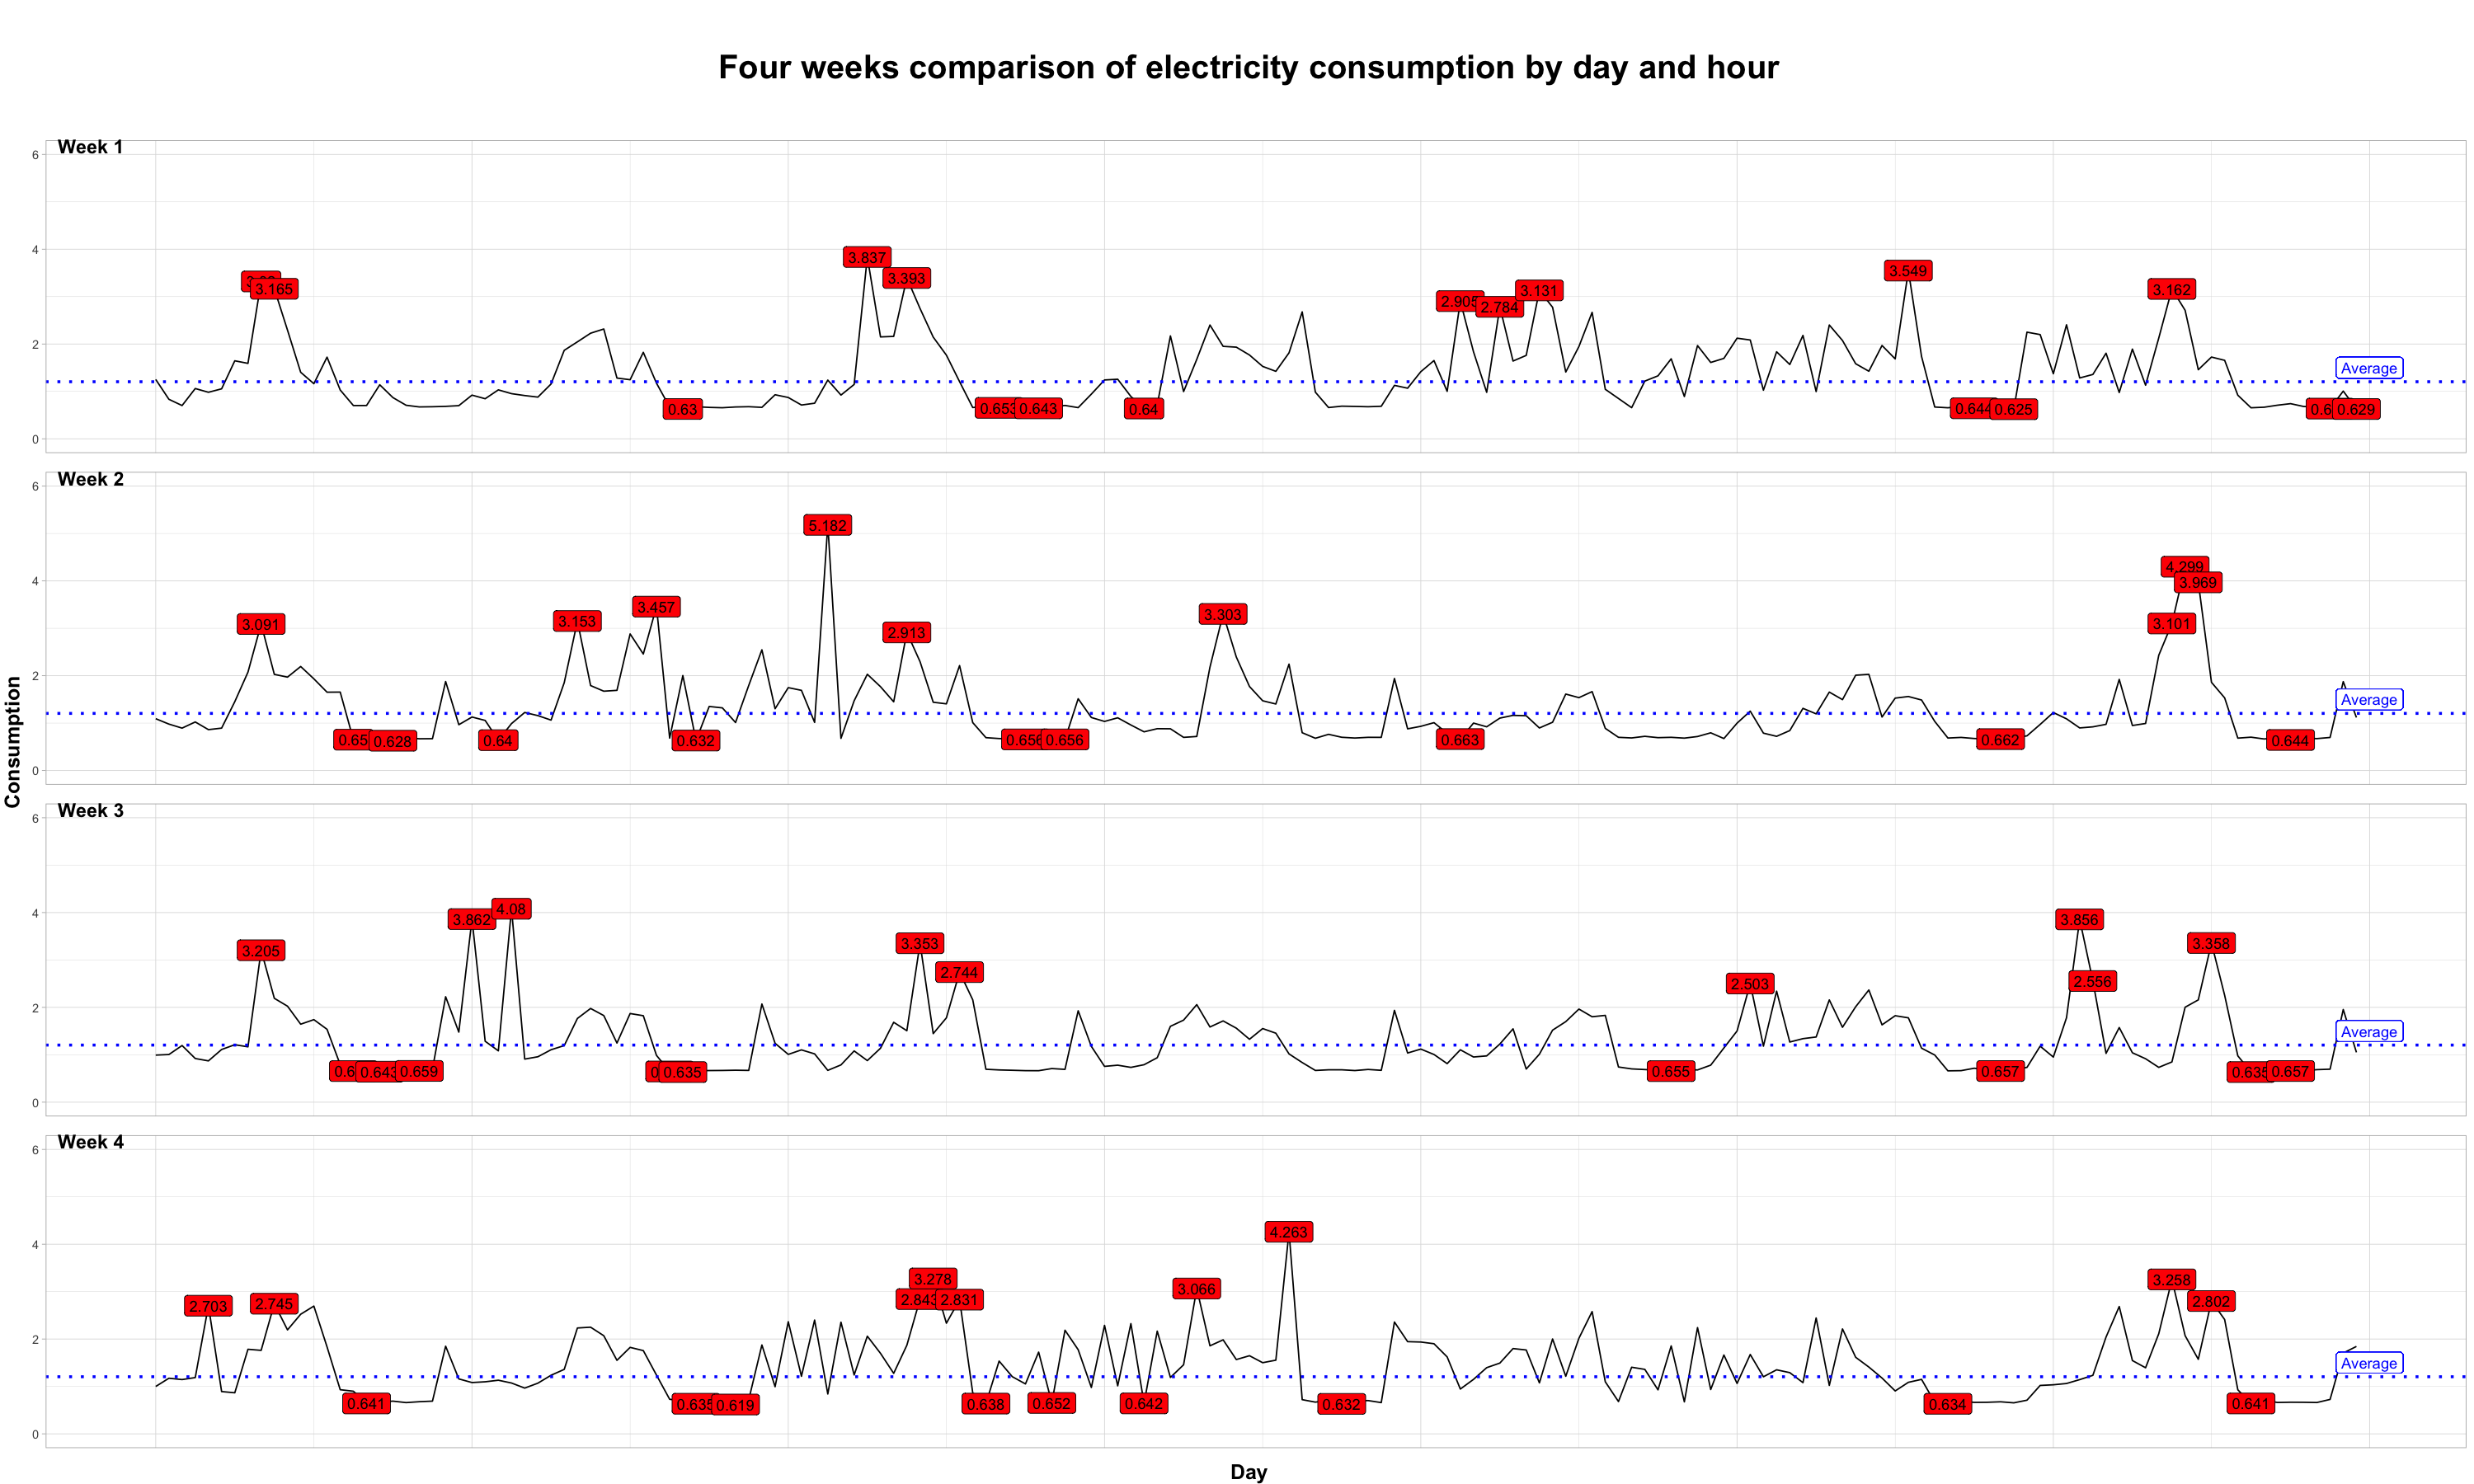

In [112]:
# Visualization of electricity consumption per day and hour
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 15)

# Plot labels definition
label_properties_list <- list("pct05_color"="black", "pct95_color"="black", "pct05_fill"="red", "pct95_fill"="red")
# Plot definitions
plt_wk1 <- line_plot(ConsDayHourWeekOneDF,      instant, consumption,label_properties_list, avg_hour_consumption)
plt_wk2 <- line_plot(ConsDayHourWeekTwoDF,      instant, consumption,label_properties_list, avg_hour_consumption)
plt_wk3 <- line_plot(ConsDayHourWeekThreeDF,    instant, consumption,label_properties_list, avg_hour_consumption)
plt_wk4 <- line_plot(ConsDayHourWeekFourDF,     instant, consumption,label_properties_list, avg_hour_consumption)

# Grid of plots definition
global_grid <- plot_grid(
    plt_wk1, plt_wk2, plt_wk3, plt_wk4,
    labels = c("Week 1", "Week 2", "Week 3", "Week 4"), label_y = 1,
    ncol = 1, nrow = 4
)

# Titles definition
title       <- ggdraw() + draw_label("Four weeks comparison of electricity consumption by day and hour", fontface = "bold", size = 24)
x_title     <- textGrob("Day", gp = gpar(fontface="bold", col="black", fontsize = 15))
y_title     <- textGrob("Consumption", gp = gpar(fontface="bold", col="black", fontsize = 15), rot=90)
plot        <- plot_grid(title, global_grid, ncol = 1, rel_heights = c(0.1, 1))

# Arrange the plot to have global x and y titles
grid.arrange(arrangeGrob(plot, bottom = x_title, left = y_title))

### b) Hourly consumption

#### Base plot and configuration

In [34]:
base_plt_hour <- ggplot(ConsHourDF, aes(x = hour, y = consumption))
base_hline_avg_hour <- geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1)
base_hline_q95_hour <- geom_hline(yintercept = q95_hour_consumption, color = "red", linetype = "dotted", linewidth = 1)
base_title_hour <- ggtitle("Distribution of electricity consumption by hour")
base_theme_hour <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )
    
maxConsHourDF <- ConsHourDF %>% group_by(hour) %>% summarise(consumption = max(consumption))


#### Plot 2: Scatter plot with jitter - Consumption by hour

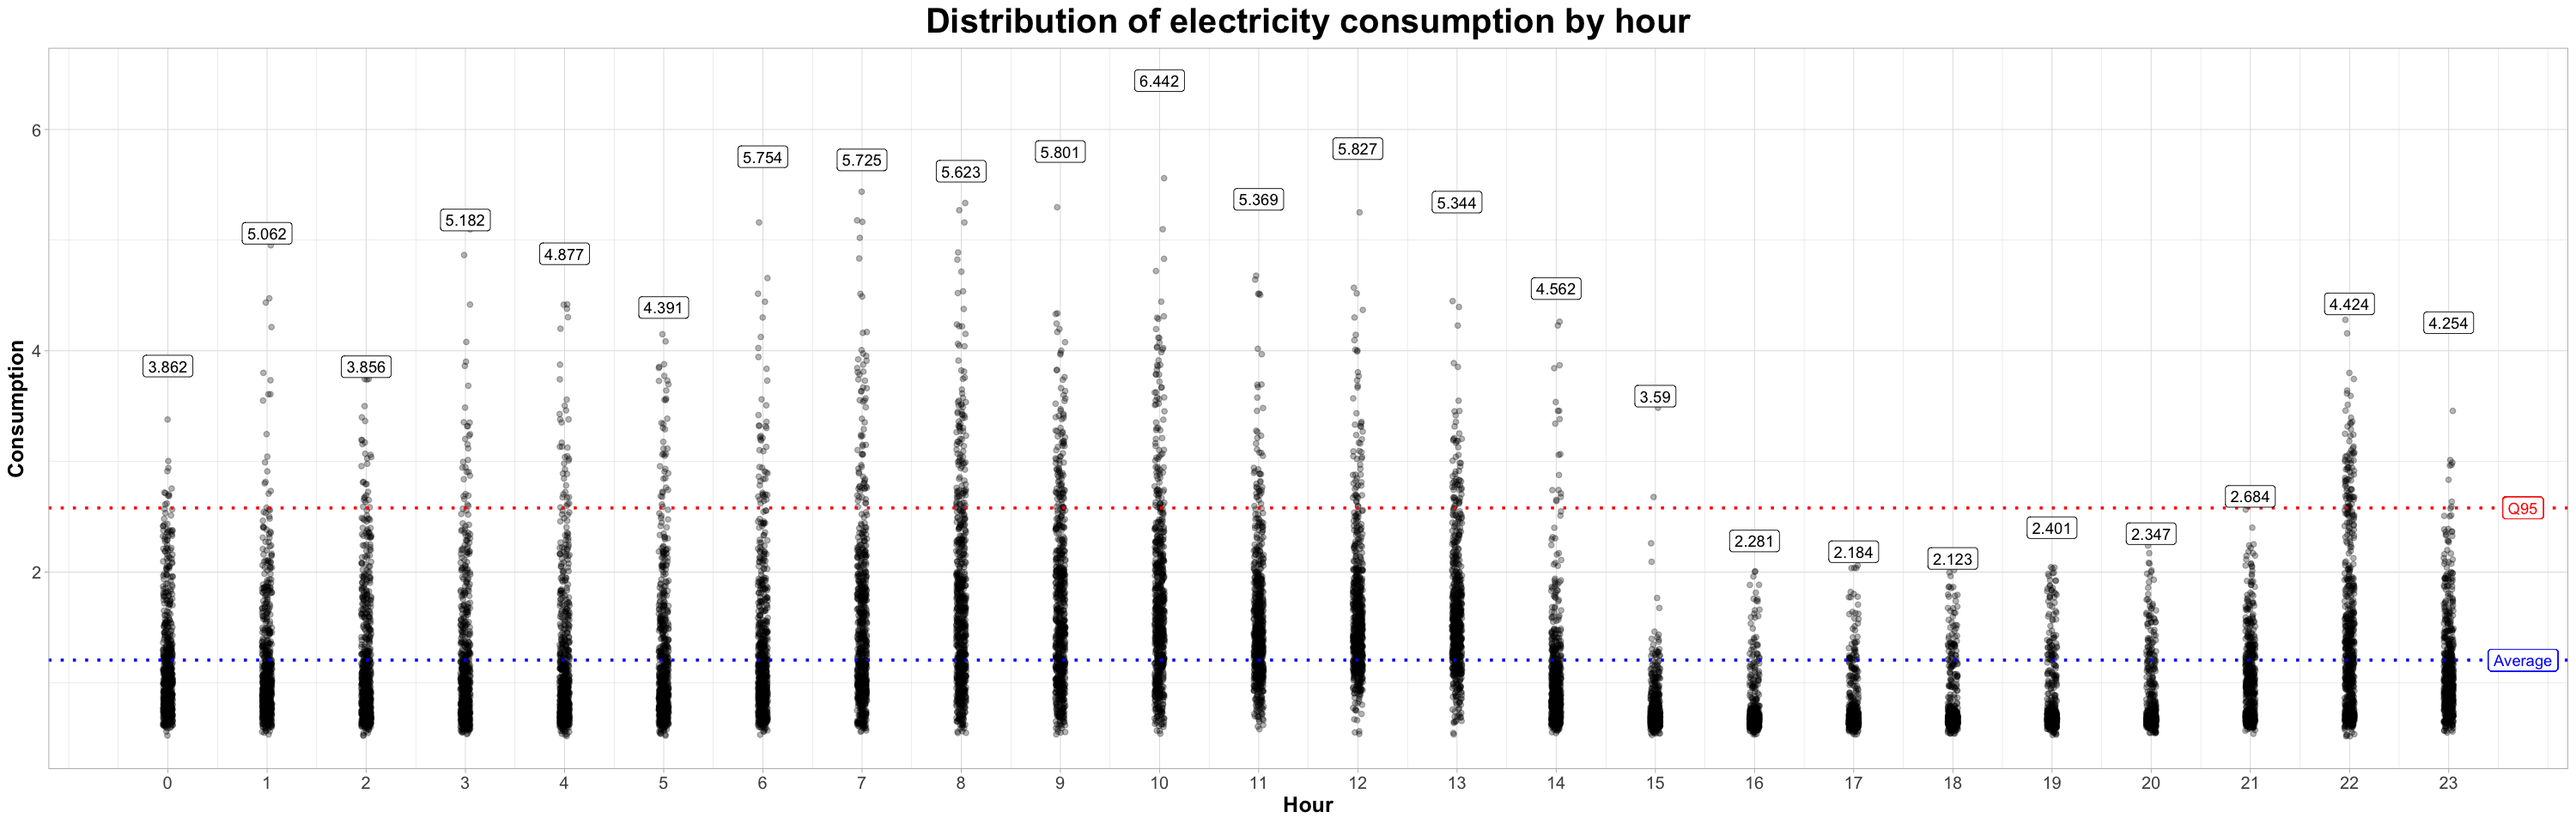

In [36]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define scatter plot
base_plt_hour + 
    geom_jitter(alpha = 0.3, width = 0.05) + 
    scale_x_continuous(breaks = 0:23, labels = 0:23) +
    base_hline_avg_hour +
    base_hline_q95_hour +
    geom_label(label = "Average", x = 23.75, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Q95", x = 23.75, y = q95_hour_consumption, color = "red") +
    geom_label(data = maxConsHourDF, aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

#### Plot 3: Boxplot - Consumption by hour

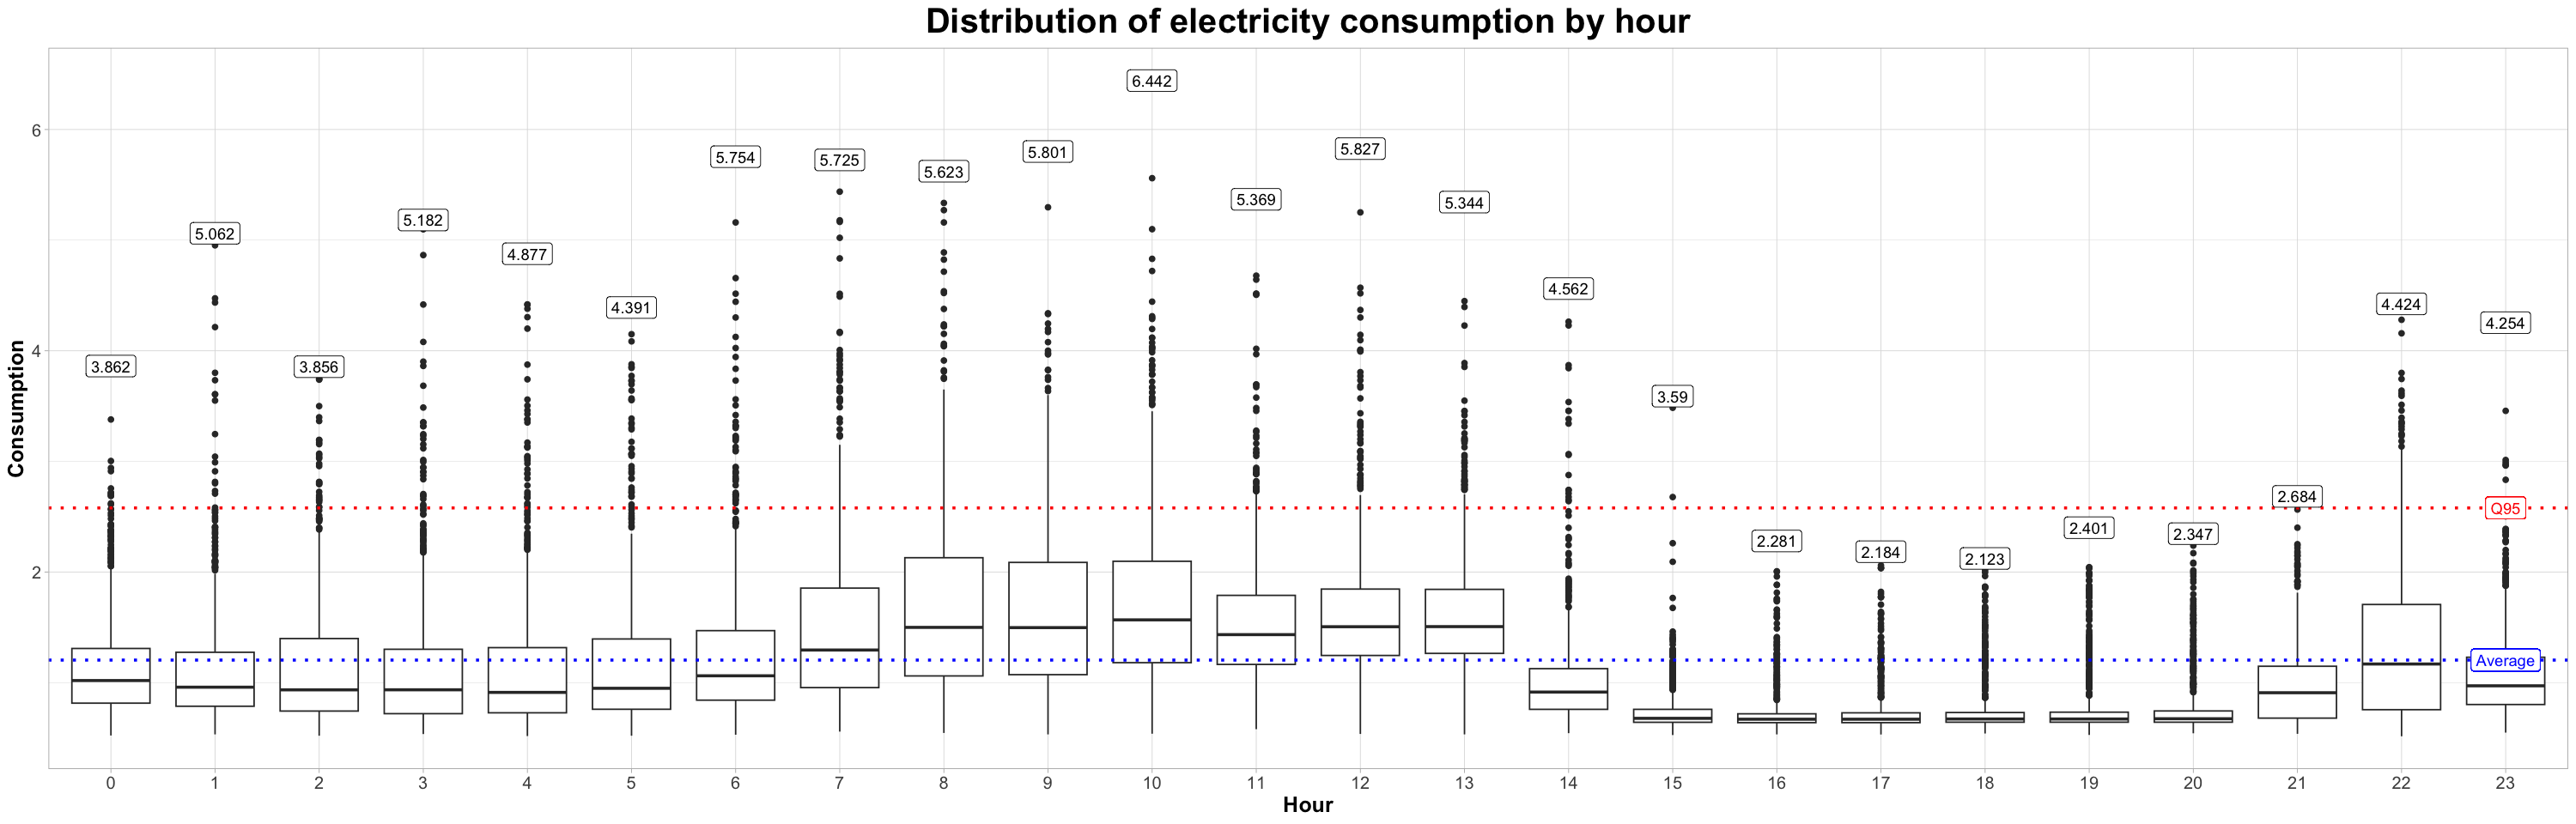

In [24]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define box plot
base_plt_hour + 
    geom_boxplot(aes(x = factor(hour))) + 
    base_hline_avg_hour +
    base_hline_q95_hour +
    geom_label(label = "Average", x = 24, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Q95", x = 24, y = q95_hour_consumption, color = "red") +
    geom_label(data = maxConsHourDF, aes(label = consumption), nudge_x = 1, color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

### c) Daily consumption

In [37]:
# Read daily electricity consumption data in csv file
ConsDayDF <- read_csv("../../../curated/electricity/gold_daily_electricity.csv", show_col_types = FALSE)

In [38]:
# Define average and 95 percentile consumption
avg_day_consumption <- mean(ConsDayDF$consumption)
q95_day_consumption <- quantile(ConsDayDF$consumption, 0.95)
# Threshold: 95%
ConsDayDF <- ConsDayDF %>% mutate(isOutlier = consumption > q95_day_consumption)

#### Base plot and configuration

In [43]:
base_plt_day <- ggplot(ConsDayDF, aes(x = day, y = consumption))
base_hline_avg_day <- geom_hline(yintercept = avg_day_consumption, color = "blue", linetype = "dotted", linewidth = 1)
base_hline_q95_day <- geom_hline(yintercept = q95_day_consumption, color = "red", linetype = "dotted", linewidth = 1)
base_title_day <- ggtitle("Distribution of electricity consumption by day")
base_labels_day <- labs(x = "Day", y = "Consumption")
base_theme_day <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

maxConsDayDF <- ConsDayDF %>% group_by(day) %>% summarise(consumption = max(consumption))

#### Plot 4: Boxplot - Consumption by day number

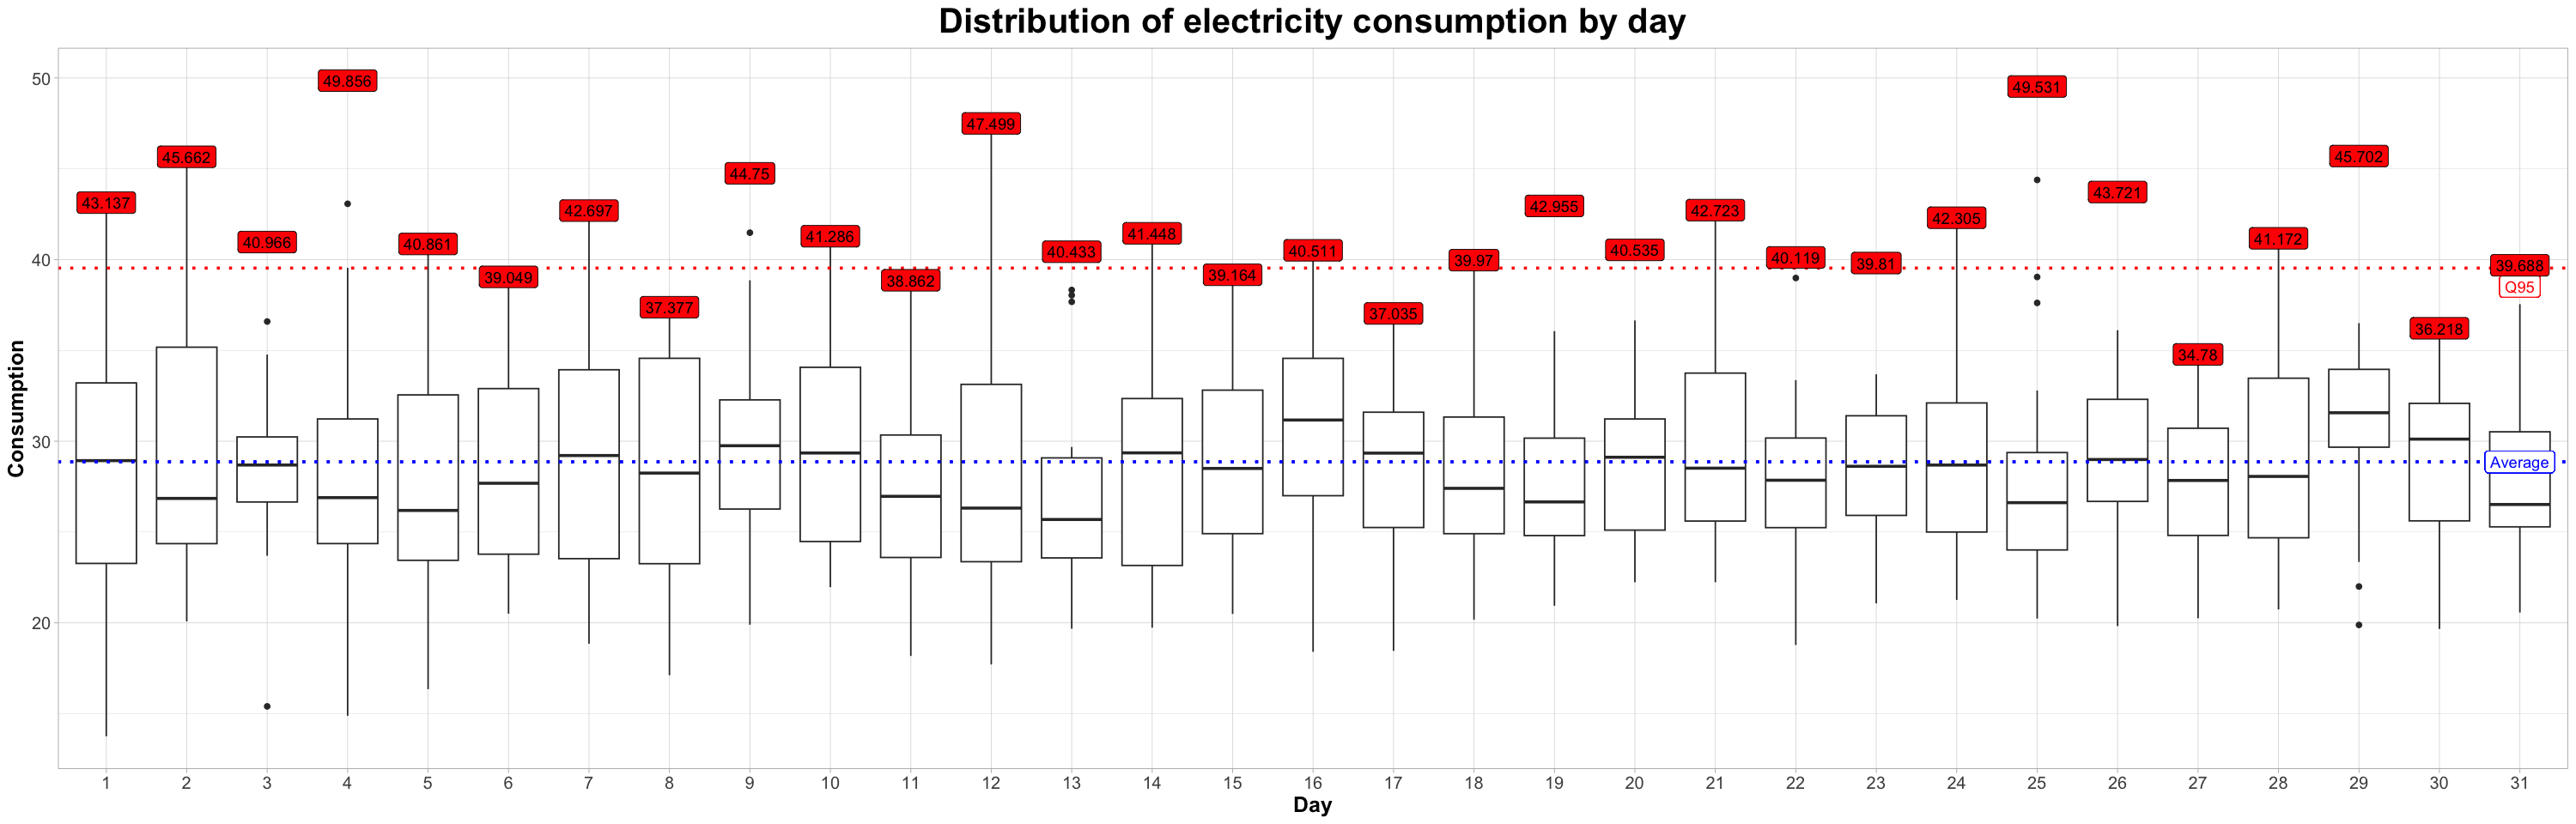

In [47]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day +
    geom_boxplot(aes(x = factor(day))) +
    base_hline_avg_day +
    base_hline_q95_day +
    geom_label(label = "Average", x = 31, y = avg_daily_consumption, color = "blue", show.legend = TRUE) +
    geom_label(label = "Q95", x = 31, y = q95_day_consumption - 1, color = "red") +
    geom_label(data = maxConsDayDF, aes(label = consumption), color = "black", fill = "red") +
    base_labels_day +
    base_title_day + 
    base_theme_day

#### Plot 5: Line plot - Consumption by day number

In [66]:
# Aggregate data by day number
ConsDayNumDF <- ConsDayDF %>%
    group_by(day) %>%
    summarize(
        consumption = sum(consumption)
    )
# Calculate average consumption
avg_day_num_consumption <- mean(ConsDayNumDF$consumption)
q95_day_num_consumption <- quantile(ConsDayNumDF$consumption, 0.95)
# Threshold: 95%
ConsDayNumDF <- ConsDayNumDF %>% mutate(isOutlier = consumption > q95_day_num_consumption)

In [67]:
base_hline_avg_day_num <- geom_hline(yintercept = avg_day_num_consumption, color = "blue", linetype = "dotted", linewidth = 1)
base_hline_q95_day_num <- geom_hline(yintercept = q95_day_num_consumption, color = "red", linetype = "dotted", linewidth = 1)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


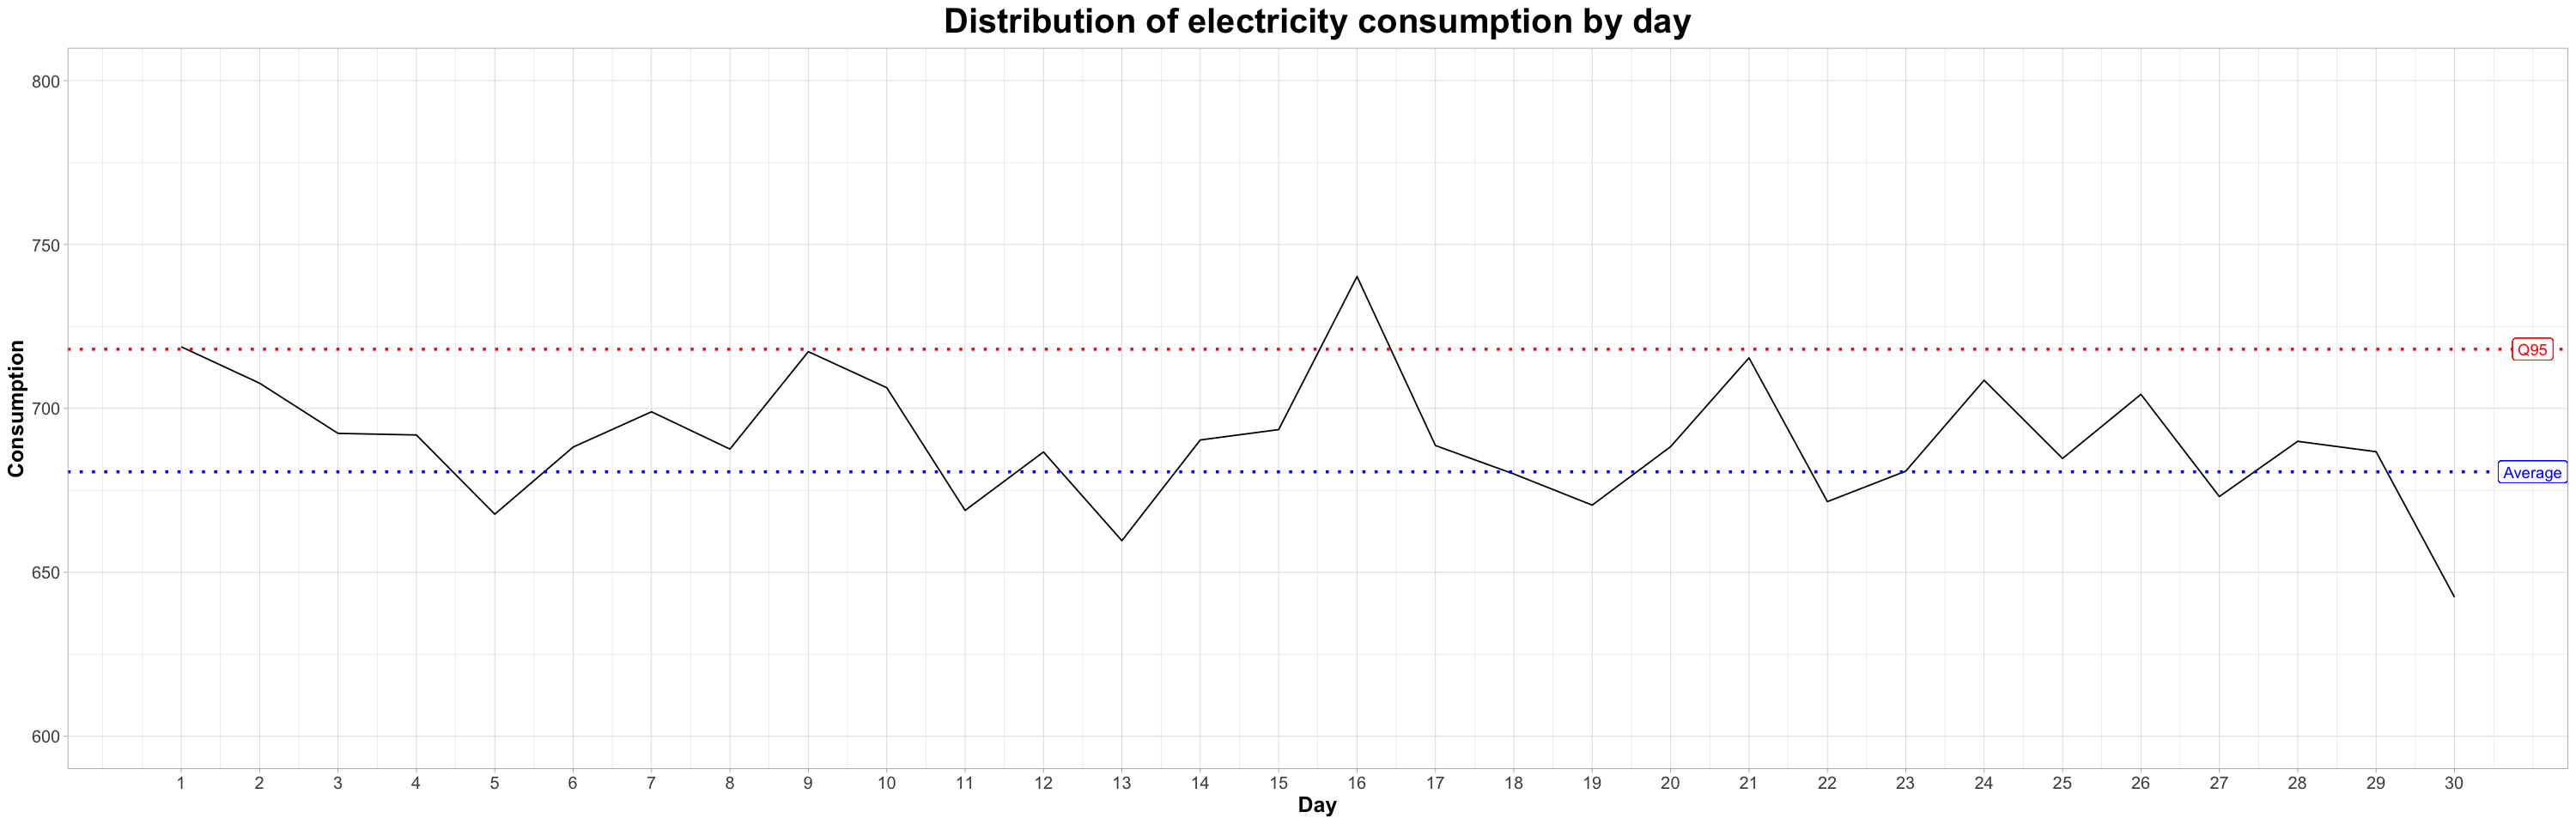

In [68]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
ggplot(ConsDayNumDF, aes(x = day, y = consumption)) +
    geom_line(aes(group = 1)) +
    base_hline_avg_day_num +
    base_hline_q95_day_num +
    scale_x_continuous(breaks = 1:30, labels = 1:30, limits = c(1, 30)) +
    ylim(c(600,800)) +
    geom_label(label = "Average", x = 31, y = avg_day_num_consumption, color = "blue") +
    geom_label(label = "Q95", x = 31, y = q95_day_num_consumption, color = "red") +
    base_labels_day +
    base_title_day + 
    base_theme_day

### d) Monthly consumption

In [59]:
# Read monthly electricity consumption data in csv file
ConsMonthDF <- read_csv("../../../curated/electricity/gold_monthly_electricity.csv", show_col_types = FALSE)

In [60]:
# Define average consumption and outliers
avg_month_consumption <- mean(ConsMonthDF$consumption)
q95_month_consumption <- quantile(ConsMonthDF$consumption, 0.95)
# Create year-month column
ConsMonthDF <- ConsMonthDF %>%
    mutate(
        isOutlier = consumption > quantile(consumption, 0.95),
        month_str = ifelse(nchar(month) == 1, paste0("0", as.character(month)), as.character(month)),
        year_month = factor(paste(year, month_str, sep = "-"))
    ) %>%
    select(-month_str)

#### Base plot and configuration

In [62]:
base_plt_month <- ggplot(ConsMonthDF, aes(x = month, y = consumption))
base_hline_avg_month <- geom_hline(yintercept = avg_month_consumption, color = "blue", linetype = "dotted", linewidth = 1)
base_hline_q95_month <- geom_hline(yintercept = q95_month_consumption, color = "red", linetype = "dotted", linewidth = 1)
base_labels_month <- labs(x = "Month", y = "Consumption")
base_title_month <- ggtitle("Distribution of electricity consumption by month")
base_theme_month <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )
maxConsMonthDF <- ConsMonthDF %>% group_by(month) %>% summarise(consumption = max(consumption))

#### Plot 6: Boxplot - Consumption by month

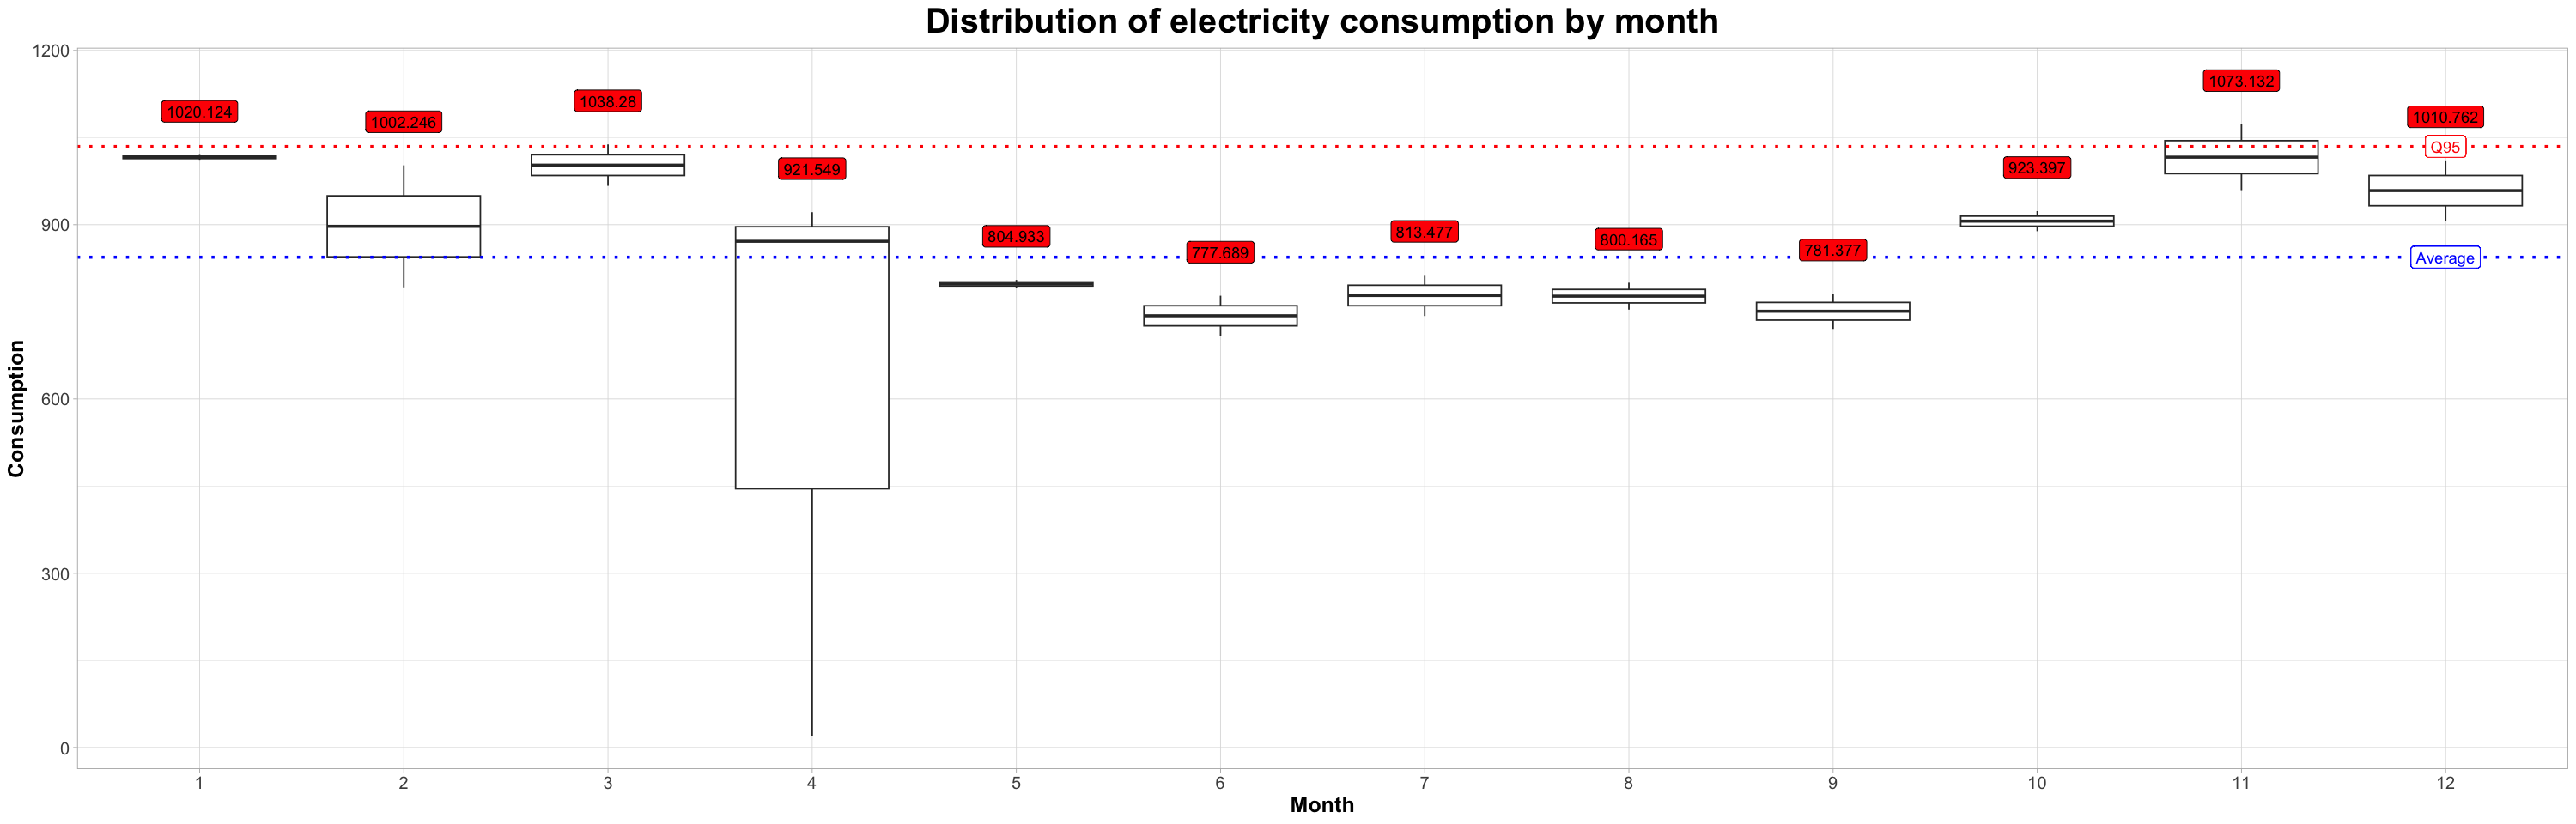

In [71]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_month +
    geom_boxplot(aes(x = factor(month))) +
    base_hline_avg_month +
    base_hline_q95_month +
    geom_label(label = "Average", x = 12, y = avg_month_consumption, color = "blue") +
    geom_label(label = "Q95", x = 12, y = q95_month_consumption, color = "red") +
    geom_label(data = maxConsMonthDF, aes(label = consumption), nudge_y = 75, color = "black", fill = "red") +
    base_labels_month +
    base_title_month + 
    base_theme_month

#### Plot 7: Line plot - Consumption by month

In [21]:
# Aggregate data by month number
ElecMonthDF2 <- ElecMonthDF %>%
    group_by(month) %>%
    summarize(
        consumption = sum(consumption)
    )
# Calculate average consumption
avg_monthly_cons_2 <- mean(ElecMonthDF2$consumption)

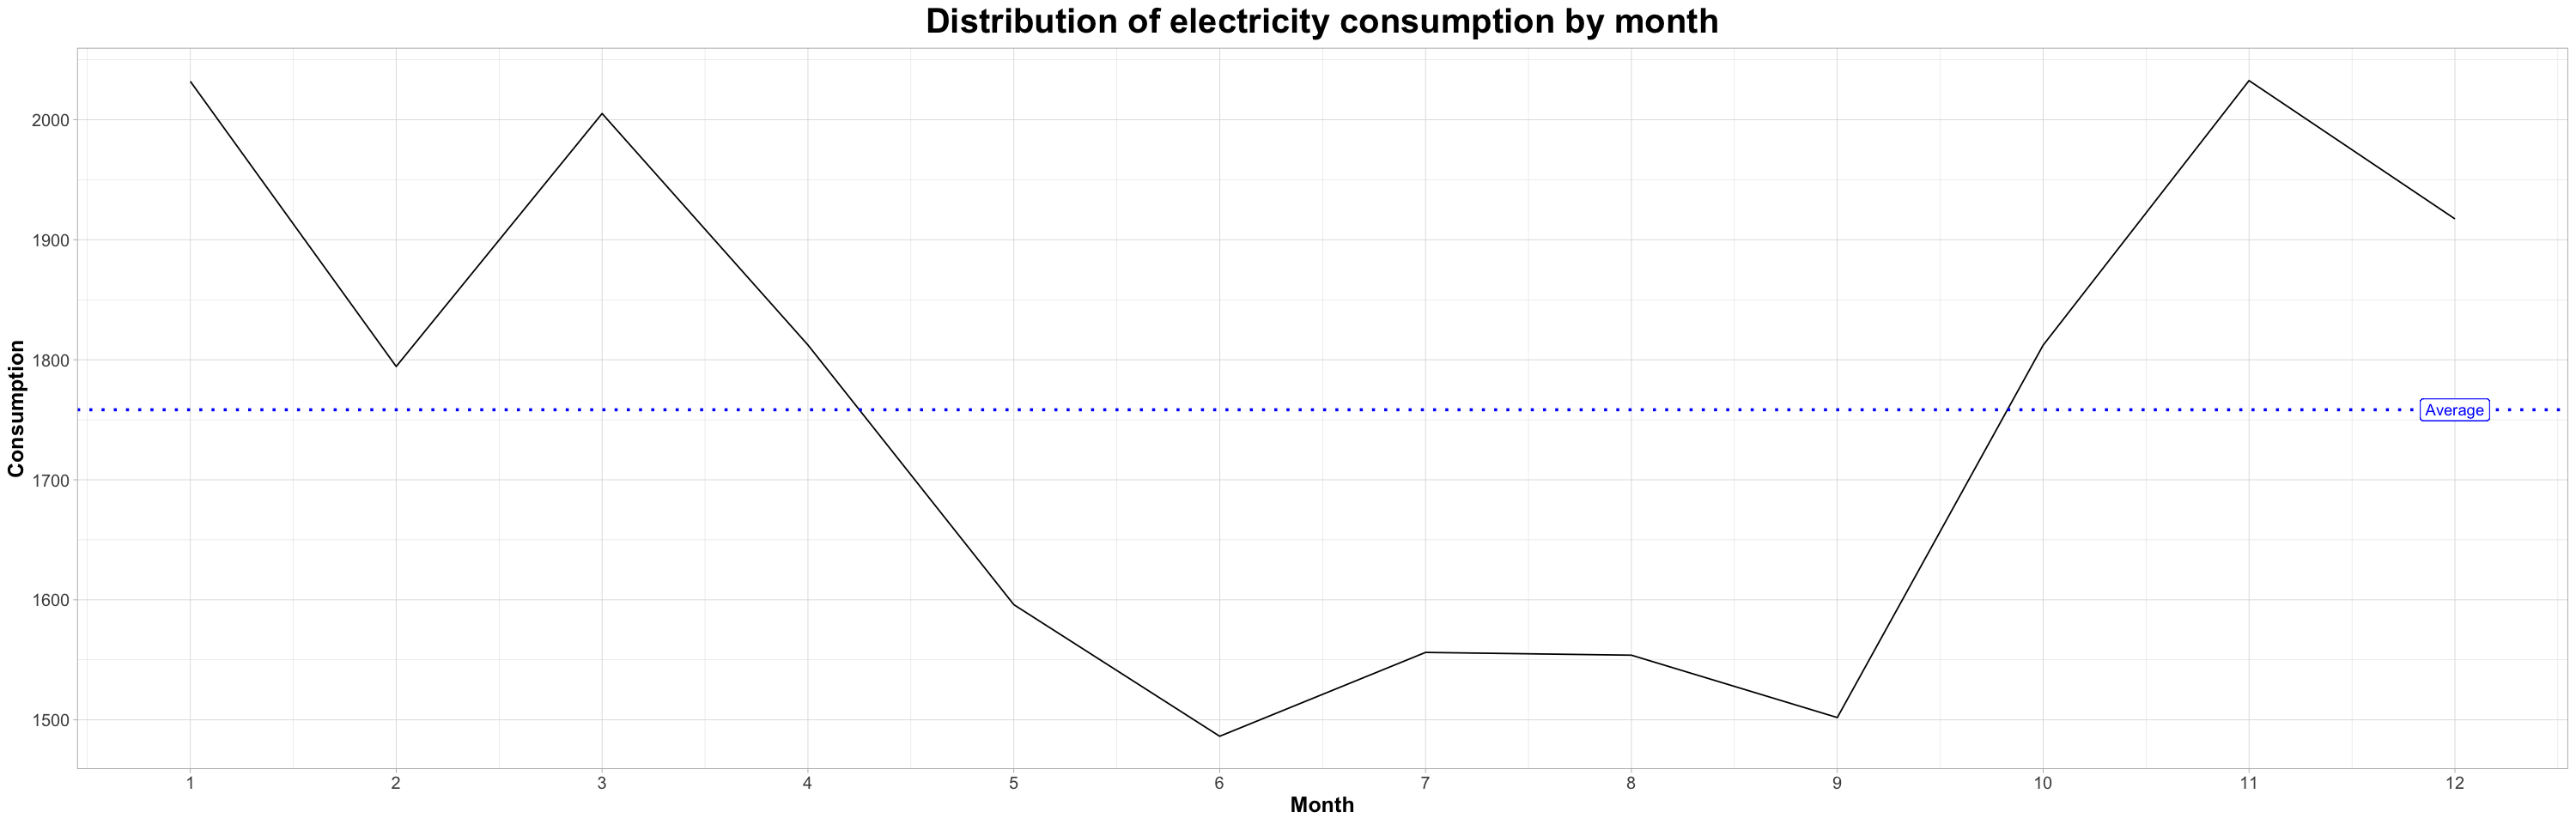

In [22]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
ggplot(ElecMonthDF2, aes(x = month, y = consumption)) +
    geom_line(aes(group = 1)) +
    geom_hline(yintercept = avg_monthly_cons_2, color = "blue", linetype = "dotted", size = 1) +
    scale_x_continuous(breaks = 1:12, labels = 1:12, limits = c(1, 12)) +
    geom_label(label = "Average", x = 12, y = avg_monthly_cons_2, color = "blue") +
    labs(x = "Month", y = "Consumption") +
    base_title_month + 
    base_theme_month

#### Plot 8: Line plot - Consumption by year and month

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


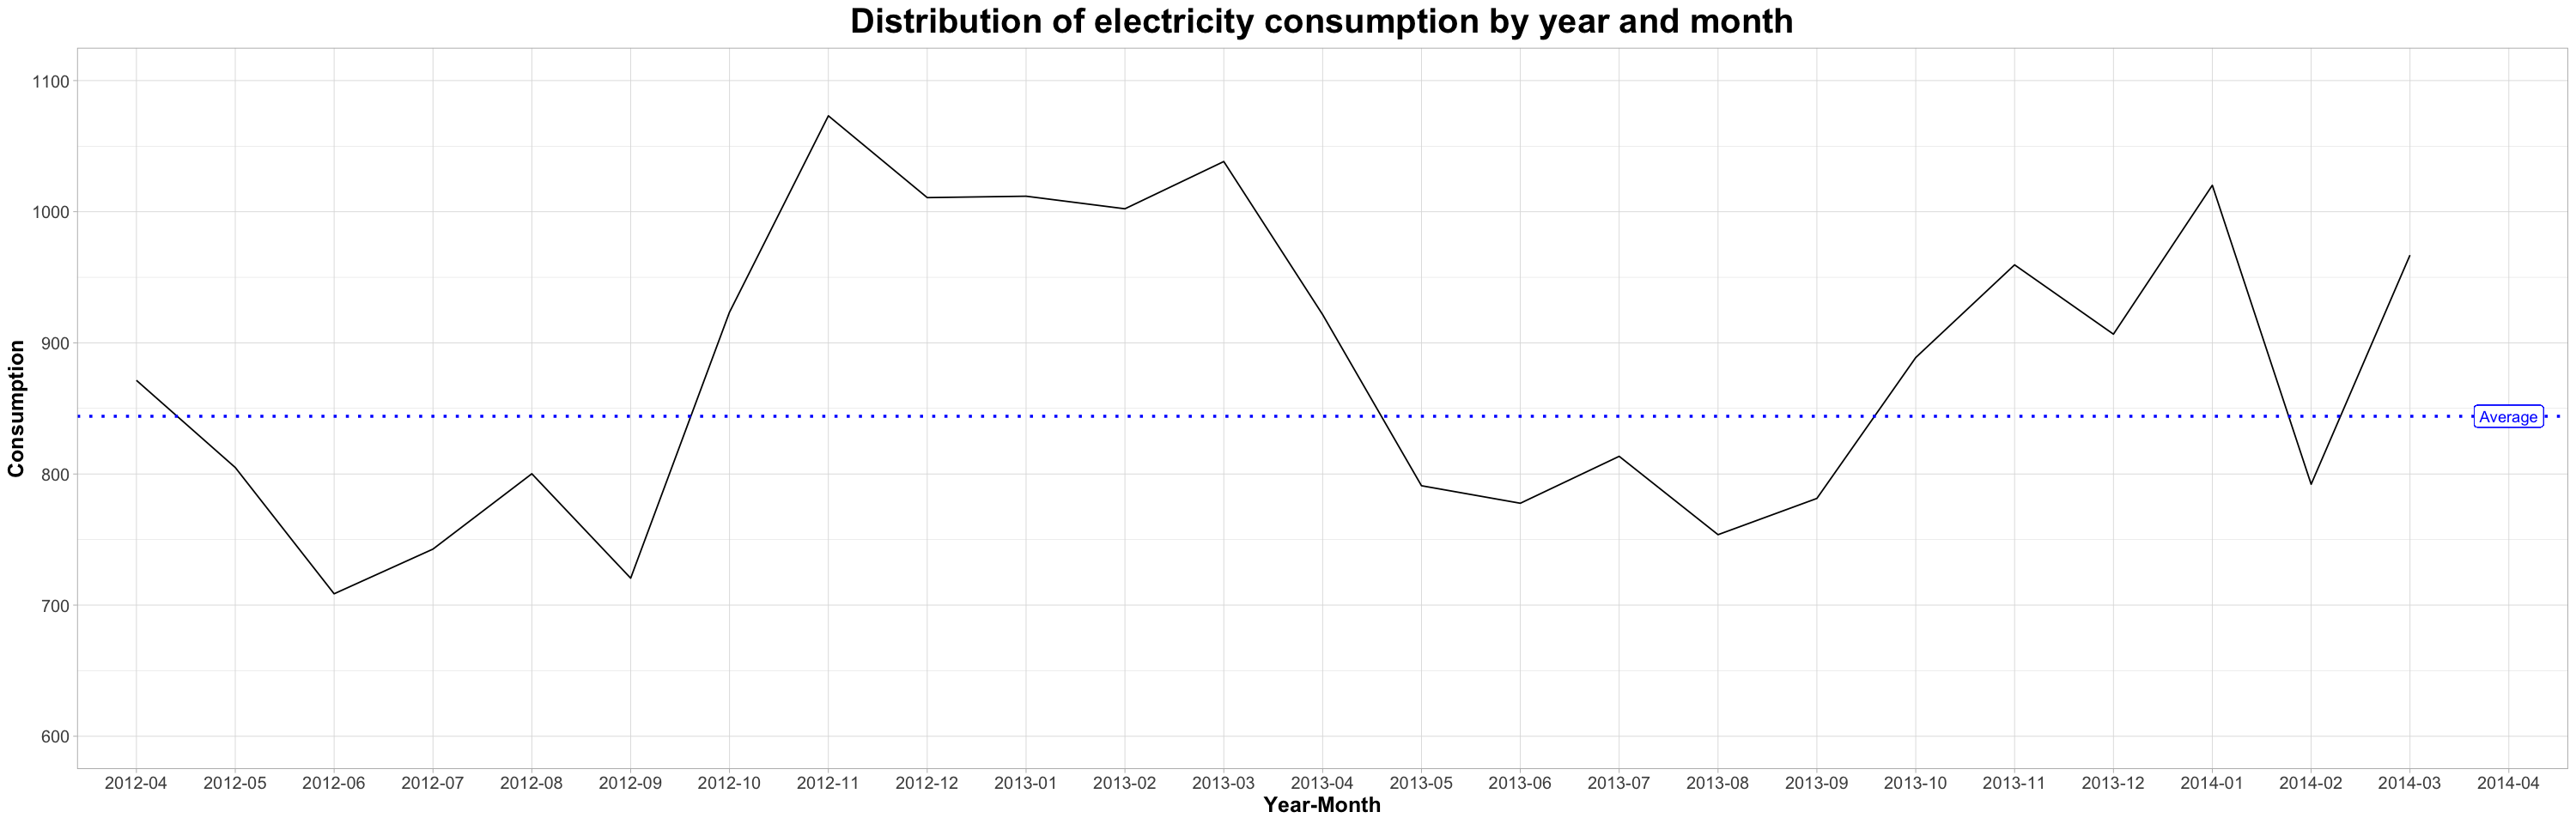

In [23]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
base_plt_month +
    geom_line(aes(x = factor(year_month), group = 1)) +
    base_hline_month +
    ylim(c(600, 1100)) +
    geom_label(label = "Average", x = "2014-04", y = avg_monthly_consumption, color = "blue", show.legend = TRUE) +
    labs(x = "Year-Month", y = "Consumption") +
    ggtitle("Distribution of electricity consumption by year and month") + 
    base_theme_month